In [19]:
!pip install cdsapi xarray netCDF4 numpy pandas matplotlib cartopy pillow

In [4]:
import cdsapi
c = cdsapi.Client()
print("CDS API is working!")

2025-06-01 18:22:20,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


CDS API is working!


In [6]:
import cdsapi

dataset = "reanalysis-era5-single-levels"

request = {
    "product_type": "reanalysis",
    "variable": ["10m_u_component_of_wind", "10m_v_component_of_wind"],
    "year": "2025",
    "month": "05",
    "day": [
        "25", "26", "27", "28", "29", "30"
    ],
    "time": [f"{h:02d}:00" for h in range(0, 24, 3)],
    "format": "netcdf",
    "area": [37.5, 68.7, 6.7, 97.25]
}

client = cdsapi.Client()

output_file = "E:/Wind/India_Wind_25to30May2025.nc"

client.retrieve(dataset, request, output_file)

print(f"Data successfully downloaded to {output_file}")

2025-06-01 18:26:40,458 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-01 18:26:41,767 INFO Request ID is 65ace843-8d93-4454-88cc-548d75367887
2025-06-01 18:26:42,003 INFO status has been updated to accepted
2025-06-01 18:27:04,243 INFO status has been updated to running
2025-06-01 18:27:33,304 INFO status has been updated to successful
                                                                                        

Data successfully downloaded to E:/Wind/India_Wind_25to30May2025.nc


In [16]:
import geopandas as gpd

india = gpd.read_file("E:/Wind/India Shapefile With Kashmir/India.shp")

india = india.to_crs(epsg=4326)


C:\Users\subha\AppData\Local\Temp\ipykernel_9984\1613283035.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  inside = points_gdf.within(india.unary_union)


✅ Wind streamline animation saved as GIF.


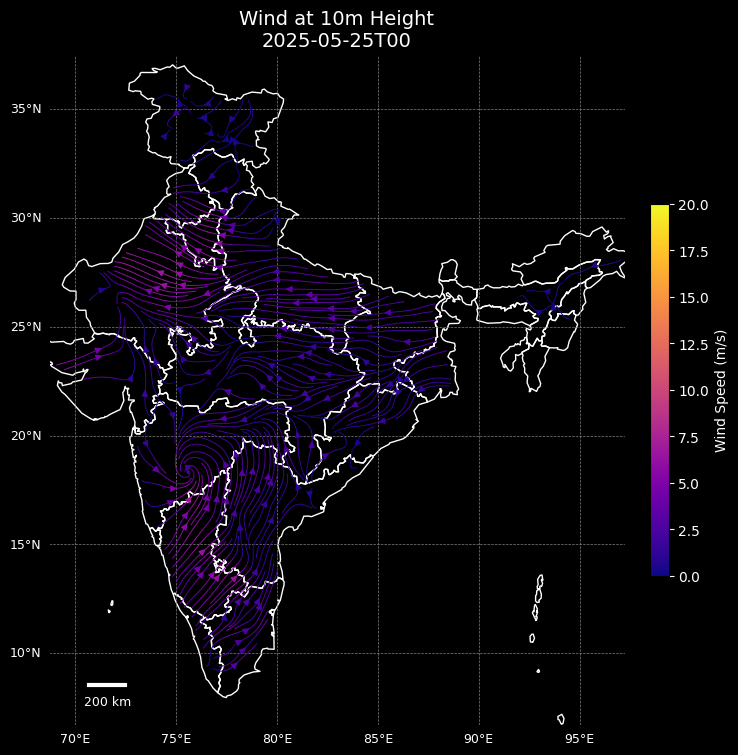

In [27]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import numpy as np
from shapely.geometry import Point
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

india = gpd.read_file("E:/Wind/India Shapefile With Kashmir/India.shp")
ds = xr.open_dataset("E:/Wind/India_Wind_25to30May2025.nc")

u = ds['u10']
v = ds['v10']
lons = ds.longitude.values
lats = ds.latitude.values
times = ds.valid_time.values

lon2d, lat2d = np.meshgrid(lons, lats)
points = np.array([lon2d.flatten(), lat2d.flatten()]).T
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in points], crs="EPSG:4326")

inside = points_gdf.within(india.unary_union)
mask = inside.values.reshape(lat2d.shape)

fig = plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('black')
ax.set_extent([68.7, 97.25, 6.7, 37.5], crs=ccrs.PlateCarree())

india.boundary.plot(ax=ax, edgecolor='white', linewidth=1)

cmap = plt.cm.plasma 
norm = mcolors.Normalize(vmin=0, vmax=20)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Wind Speed (m/s)', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

def add_scalebar(ax, length_km=200, location=(0.05, 0.05), linewidth=3, text_color='white'):
    extent = ax.get_extent(ccrs.PlateCarree())
    lon_start = extent[0]
    lat_start = extent[2]

    km_per_deg = 111
    length_deg = length_km / km_per_deg

    bar_lon = lon_start + (extent[1] - extent[0]) * location[0]
    bar_lat = lat_start + (extent[3] - extent[2]) * location[1]

    ax.plot(
        [bar_lon, bar_lon + length_deg], [bar_lat, bar_lat],
        transform=ccrs.PlateCarree(),
        color=text_color, linewidth=linewidth
    )

    ax.text(
        bar_lon + length_deg / 2, bar_lat - 0.5,
        f"{length_km} km",
        transform=ccrs.PlateCarree(),
        ha='center', va='top',
        color=text_color, fontsize=9
    )

def animate(i):
    ax.clear()
    ax.set_facecolor('black')
    ax.set_extent([68.7, 97.25, 6.7, 37.5], crs=ccrs.PlateCarree())

    
    india.boundary.plot(ax=ax, edgecolor='white', linewidth=1)

    
    gl = ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'color': 'white', 'fontsize': 9}
    gl.ylabel_style = {'color': 'white', 'fontsize': 9}

    u_data = u[i].values
    v_data = v[i].values
    u_masked = np.where(mask, u_data, np.nan)
    v_masked = np.where(mask, v_data, np.nan)
    wind_speed = np.sqrt(u_masked**2 + v_masked**2)

    ax.streamplot(
        lon2d, lat2d,
        u_masked, v_masked,
        transform=ccrs.PlateCarree(),
        color=wind_speed,
        cmap=cmap,
        norm=norm,
        linewidth=0.7,
        density=5
    )

    ax.set_title(
        f"Wind at 10m Height\n{np.datetime_as_string(times[i], unit='h')}",
        fontsize=14,
        color='white'
    )

    add_scalebar(ax, length_km=200, location=(0.07, 0.06), text_color='white')

anim = animation.FuncAnimation(fig, animate, frames=len(times), interval=500)

anim.save("E:/Wind/India_Wind_Streamlines.gif", writer="pillow", dpi=900)
print("✅ Wind streamline animation saved as GIF.")
